In [102]:
import numpy as np
import nestle
import corner
import matplotlib.pyplot as plt
import scipy.interpolate as spint

In [74]:
from settings import lightcurve_dir, config_dir, template_dir
from lightcurve import LightCurve, Outburst, read_template
from utils import read_outburst_numbers, read_priors

In [75]:
outburst_numbers = read_outburst_numbers(filename=config_dir+'outburst_numbers.txt')

In [76]:
lightcurve_detections_file = lightcurve_dir + "OJ287_Vmag.txt"
lightcurve_nondetections_file = lightcurve_dir + "OJ287_Vmag_upper.txt"

lightcurve_detections = LightCurve(lightcurve_detections_file)
lightcurve_nondetections = LightCurve(lightcurve_nondetections_file, Mref=lightcurve_detections.Mref)

In [77]:
cuts = np.genfromtxt(config_dir+"lightcurve_cuts.txt")

In [78]:
labels = [int(cut_min) for cut_min,cut_max in cuts]

In [79]:
priors = read_priors(config_dir+"priors.txt")

In [80]:
templates = [read_template(template_dir+"oj287_templ_all.txt".format(label)) for label in labels]

In [81]:
outbursts = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, template, label=label) for cut,prior,template,label in zip(cuts,priors,templates,labels)]

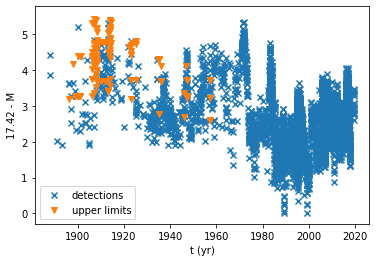

In [82]:
# Figure 1

def plot_full_lightcurve(lightcurve_det, lightcurve_cen):
    plt.scatter(lightcurve_det.t, lightcurve_det.M, marker='x', label="detections")
    plt.scatter(lightcurve_cen.t, lightcurve_cen.M, marker='v', label='upper limits')
    plt.xlabel("t (yr)")
    plt.ylabel("{} - M".format(lightcurve_det.Mref))
    plt.legend()
    plt.show()

plot_full_lightcurve(lightcurve_detections, lightcurve_nondetections)

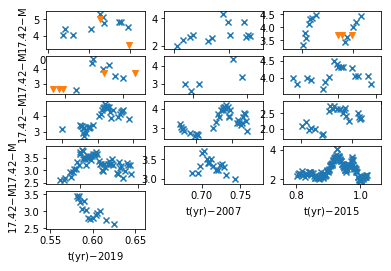

In [83]:
# Figure 2

def plot_outburst_lightcurves(outbursts):
    no_of_obs = len(outbursts)
    no_of_cols = 3
    no_of_rows = int(np.ceil(no_of_obs/no_of_cols))
    
    for idx, outburst in enumerate(outbursts):
        plt.subplot(no_of_rows, no_of_cols, idx+1)
        
        plt.scatter(outburst.lightcurve_det.t-outburst.year, outburst.lightcurve_det.M, marker='x')
        plt.scatter(outburst.lightcurve_cen.t-outburst.year, outburst.lightcurve_cen.M, marker='v')
        
        plt.xlabel("t(yr)$-${}".format(outburst.year))
        
        if idx%3==0:
            plt.ylabel("{}$-$M".format(outburst.lightcurve_det.Mref))
        
    plt.show()

plot_outburst_lightcurves(outbursts)

In [84]:
# Table 2

for ob in outbursts:
    print(ob.nob, ob.year, len(ob.lightcurve_det.t), len(ob.lightcurve_cen.t))

5 1912 10 2
8 1934 13 0
11 1947 12 3
12 1957 7 5
14 1964 5 0
16 1972 17 0
17 1982 35 0
18 1984 35 0
20 1995 22 0
21 2005 53 0
22 2007 18 0
23 2015 131 0
24 2019 15 0


In [85]:
def maxlike(result):
    idx = np.argmax(result.logl)
    return result.samples[idx]

In [86]:
def plot_fit(outburst, params):
    plt.scatter(outburst.lightcurve_det.t, outburst.lightcurve_det.M)
    plt.scatter(outburst.lightcurve_cen.t, outburst.lightcurve_cen.M)
    tmpl_to_obs = outburst.templ_to_obs(params)
    plt.plot(tmpl_to_obs.t, tmpl_to_obs.M)
    plt.axvline(params[0])

In [87]:
years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()
for ob, bw in zip(outbursts, bandwidths):
    ob.run_sampler()
    ob.process_samples(bw)
    #ob.save_samples("1tmpl/oj287_tobs_samples_{}.txt".format(ob.year))
    #ob.save_kde("1tmpl/oj287_tobs_kde_{}.txt".format(ob.year))

Running sampler for year 1912


/home/abhimanyu/.local/lib/python3.6/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


Running sampler for year 1934
Running sampler for year 1947
Running sampler for year 1957
Running sampler for year 1964
Running sampler for year 1972
Running sampler for year 1982
Running sampler for year 1984
Running sampler for year 1995
Running sampler for year 2005
Running sampler for year 2007
Running sampler for year 2015
Running sampler for year 2019


-0.10165408004513735 0.39876062526994516
-0.0895676078343879 0.5828103956717562
-0.07748113562363845 0.48631265778719135
-0.06539466341288899 0.5083893993226277
-0.053308191202139546 0.5901619404157201
-0.04122171899139009 0.3740780166617471
-0.02913524678064064 0.2966624790702673
-0.017048774569891186 0.39338170030636876
-0.004962302359141732 0.5087580843417926
0.0071241698516077215 0.9126411851953358
0.019210642062357175 1.5341144194967675
0.03129711427310662 1.6232248152553863
0.04338358648385607 1.4074113103389752
0.05547005869460553 0.9051386299549926
0.06755653090535498 1.0486080893460812
0.07964300311610442 1.2519099194227241
0.09172947532685387 0.7644607665752648
0.10381594753760333 0.3054634631508448
0.11590241974835279 0.317830009505234
0.12798889195910224 0.4054537236544119


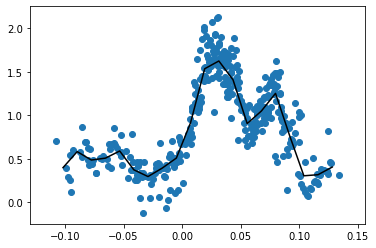

In [109]:
ts = []
Ms = []
for ob in outbursts:
    params = maxlike(ob.result)
    lc_al = ob.obs_to_templ(params[:-1])
    #plt.scatter(lc_al.t, lc_al.M)
    ts.extend(lc_al.t)
    Ms.extend(lc_al.M)

plt.scatter(ts,Ms)

tmin = np.min(ts)
tmax = np.max(ts)

nbin = 20

ttmpl = []
Mtmpl = []

for ibin in range(nbin):
    tbinmin = tmin + ibin*(tmax-tmin)/nbin
    tbinmax = tmin + (ibin+1)*(tmax-tmin)/nbin
    mask = np.logical_and(ts>=tbinmin, ts<=tbinmax)
    tbin = (tbinmin+tbinmax)/2
    Mbin = np.median(np.array(Ms)[mask])
    
    ttmpl.append(tbin)
    Mtmpl.append(Mbin)
    
    print(tbin,Mbin)

plt.plot(ttmpl, Mtmpl, c='k')

templ1 = LightCurve(ts=np.array(ttmpl), Ms=np.array(Mtmpl))

L2 0.20061672694549632
L1 0.16146363132630995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


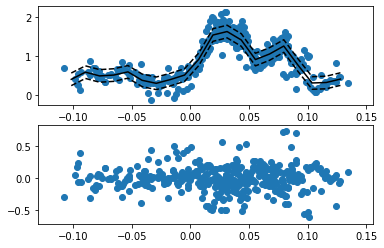

In [110]:


#Mtmpl[-1] = Mtmpl[-2]
plt.subplot(211)
plt.scatter(ts, Ms)
plt.plot(ttmpl, Mtmpl, c='k')
#templ1 = LightCurve(ts=np.array(ttmpl), Ms=np.array(Mtmpl))

plt.subplot(212)
#diffs = np.interp(ts, ttmpl, Mtmpl) - Ms
diffs = spint.interp1d(ttmpl, Mtmpl, bounds_error=False, fill_value=(Mtmpl[0],Mtmpl[-1]))(ts) - Ms
plt.scatter(ts,diffs)
print("L2", (sum(diffs**2)/len(diffs))**0.5)
print("L1", np.median(np.abs(diffs))/0.67449)
templ_err = np.median(np.abs(diffs))/0.67449

plt.subplot(211)
plt.plot(ttmpl, np.array(Mtmpl)+templ_err, c='k', ls='--')
plt.plot(ttmpl, np.array(Mtmpl)-templ_err, c='k', ls='--')

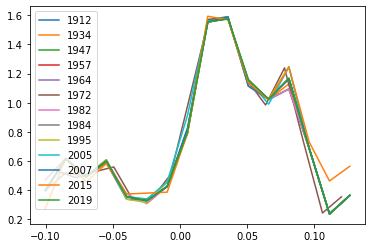

In [100]:
templates_rr = []

for iob in range(len(outbursts)):
    ts = []
    Ms = []
    for job,ob in enumerate(outbursts):
        if job != iob:
            params = maxlike(ob.result)
            lc_al = ob.obs_to_templ(params[:-1])
            #plt.scatter(lc_al.t, lc_al.M)
            ts.extend(lc_al.t)
            Ms.extend(lc_al.M)

    #plt.subplot(4,4,iob+1)
    #plt.scatter(ts,Ms)

    tmin = np.min(ts)
    tmax = np.max(ts)

    #nbin = 16

    ttmpl = []
    Mtmpl = []

    for ibin in range(nbin):
        tbinmin = tmin + ibin*(tmax-tmin)/nbin
        tbinmax = tmin + (ibin+1)*(tmax-tmin)/nbin
        mask = np.logical_and(ts>=tbinmin, ts<=tbinmax)
        tbin = (tbinmin+tbinmax)/2
        Mbin = np.median(np.array(Ms)[mask])

        ttmpl.append(tbin)
        Mtmpl.append(Mbin)

        #print(tbin,Mbin,sum(mask))

    plt.plot(ttmpl, Mtmpl, label=str(outbursts[iob].year))

    tmpl_rr = LightCurve(ts=np.array(ttmpl), Ms=np.array(Mtmpl))
    templates_rr.append(tmpl_rr)

plt.legend(loc="upper left")

In [42]:
outbursts_1t = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, templ1, label=label) for cut,prior,label in zip(cuts,priors,labels)]
outbursts_rr = [Outburst(outburst_numbers[label], lightcurve_detections, lightcurve_nondetections, cut, prior, templr, label=label) for cut,prior,templr,label in zip(cuts,priors,templates_rr,labels)]

In [56]:
years, bandwidths = np.genfromtxt("../../data/config/bandwidths.txt").transpose()
for ob1, obr, bw in zip(outbursts_1t, outbursts_rr, bandwidths):
    ob1.run_sampler()
    ob1.process_samples(bw)
    obr.run_sampler()
    obr.process_samples(bw)
    

Running sampler for year 1912
Running sampler for year 1912
Running sampler for year 1934
Running sampler for year 1934
Running sampler for year 1947


/home/abhimanyu/.local/lib/python3.6/site-packages/nestle.py:906: RuntimeWarning: invalid value encountered in double_scalars
  math.exp(logz - logz_new) * (h + logz) -


Running sampler for year 1947
Running sampler for year 1957
Running sampler for year 1957
Running sampler for year 1964
Running sampler for year 1964
Running sampler for year 1972
Running sampler for year 1972
Running sampler for year 1982
Running sampler for year 1982
Running sampler for year 1984
Running sampler for year 1984
Running sampler for year 1995
Running sampler for year 1995
Running sampler for year 2005
Running sampler for year 2005
Running sampler for year 2007
Running sampler for year 2007
Running sampler for year 2015
Running sampler for year 2015
Running sampler for year 2019
Running sampler for year 2019


1912.999111520154
1912.9996904742093
1934.142946007728
1934.1422614469668
1947.191086419765
1947.1933013918324
1957.1194953576053
1957.1212453171872
1964.247490271082
1964.2482345436613
1972.946784785814
1972.9480857135452
1982.9946217319784
1982.9942352355943
1984.1496453878756
1984.1495360886465
1995.8450265743202
1995.845059361158
2005.7793114468993
2005.7754138415075
2007.6922460028807
2007.6922427849615
2015.8967668318146
2015.8954100878386
2019.537850593998
2019.5386125256016


(-0.23205, 1.23205, -0.23205, 1.23205)

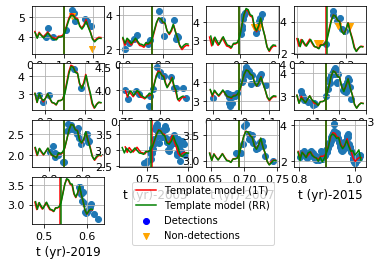

In [44]:
# Add a new figure if needed.

for idx,(ob1,obr) in enumerate(zip(outbursts_1t, outbursts_rr)):
    res = ob1.result
    #tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)[0]
    #dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)[0]
    #s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)[0]
    #A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)[0]
    tob,dM,s,A,err = maxlike(res)
    
    print(tob)
    
    yr = ob1.year
    
    plt.subplot(4,4,idx+1)
    plt.grid()
    
    model = ob1.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t-yr, model.M, color='red')
    plt.scatter(ob1.lightcurve_det.t-yr, ob1.lightcurve_det.M)
    plt.scatter(ob1.lightcurve_cen.t-yr, ob1.lightcurve_cen.M, color='orange', marker='v')
    plt.axvline(tob-yr, color='red')
    plt.xlabel("t (yr)-{}".format(yr), fontsize='12')
    plt.tick_params(labelsize=11)
    
    ####################################################################
    
    res = obr.result
    #tob = corner.quantile(res.samples[:,0], 0.5, weights=res.weights)[0]
    #dM = corner.quantile(res.samples[:,1], 0.5, weights=res.weights)[0]
    #s = corner.quantile(res.samples[:,2], 0.5, weights=res.weights)[0]
    #A = corner.quantile(res.samples[:,3], 0.5, weights=res.weights)[0]
    tob,dM,s,A,err = maxlike(res)
    
    print(tob)
    
    model = obr.templ_to_obs([tob,dM,s,A])
    plt.plot(model.t-yr, model.M, color='green')
    plt.axvline(tob-yr, color='green')
    
    
plt.subplot(4,4,15)
plt.scatter([],[],color='blue',label="Detections")
plt.scatter([],[],color='orange',marker="v",label="Non-detections")
plt.plot([],[],color='red',ls="-",label="Template model (1T)")
plt.plot([],[],color='green',ls="-",label="Template model (RR)")
plt.legend()
plt.axis('off')

0.8369802254002052 1.162062543560657
-0.01625034998843694 0.29354467531922274
0.08012838124209339 0.30135069585362545
0.0006205318190782294 0.23665744956726348
-0.18682827026581522 0.6539174709387598
0.8525811593947837 1.041321190057435
0.9671656589584054 1.0210033628933124
0.12771923482172223 0.1707896294577613
0.7941621563626049 0.8954924724545472
0.6732726474948563 0.8815140785746949
0.6641945649338294 0.7194755117662981
0.8854255255145108 0.9080747685071583
0.3372631605034544 0.7546775212294674


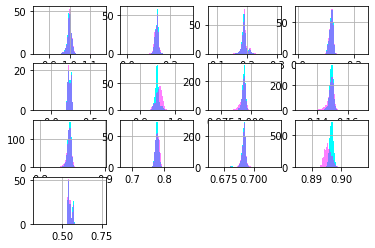

In [57]:
for idx,(ob1,obr) in enumerate(zip(outbursts_1t, outbursts_rr)):
    plt.subplot(4,4,idx+1)
    plt.grid()
    
    res1 = ob1.result
    resr = obr.result
    
    tob_samples1 = nestle.resample_equal(res1.samples[:,0], weights=res1.weights) - ob1.year
    tob_samplesr = nestle.resample_equal(resr.samples[:,0], weights=resr.weights) - obr.year
    
    median = np.median(tob_samples1)
    mad = np.median(np.abs(tob_samples1-median))
    std = 1.4826*mad
    
    left,right = median-20*std, median+20*std 
    print(left,right)
    plt.hist(tob_samples1, bins=64, density=True, color='cyan', alpha=1, range=[left,right])
    plt.hist(tob_samplesr, bins=64, density=True, color='magenta', alpha=0.5, range=[left,right])
    

In [ ]:
corner.corner()